In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
from pyspark.sql.functions import to_timestamp
from pyspark.sql import functions as F
from scipy.interpolate import make_interp_spline

     
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("Vu dep trai").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# # spark.stop()
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

In [3]:
TICKER = 'ACB'

df = spark.read.json(f'/content/drive/MyDrive/Smoll data /final_stock/{TICKER}.json',  multiLine=True)
df = df.withColumnRenamed('close', 'close_price')
df = df.withColumnRenamed('high', 'high_price')
df = df.withColumnRenamed('low', 'low_price')
df = df.withColumnRenamed('tradingDate', 'trading_date')
df = df.withColumnRenamed('open', 'open_price')
df = df.withColumnRenamed('ticker', 'ticker_name')

df = df.withColumn('trading_date', unix_timestamp(to_date(df['trading_date']), "yyyy-MM-dd").cast("timestamp"))
df.show(5)

+-----------+----------+---------+----------+-----------+-------------------+------+
|close_price|high_price|low_price|open_price|ticker_name|       trading_date|volume|
+-----------+----------+---------+----------+-----------+-------------------+------+
|     7147.0|    8234.0|   6532.0|    5050.0|        ACB|2006-11-21 00:00:00| 56500|
|     7394.0|    7861.0|   7136.0|    6038.0|        ACB|2006-11-22 00:00:00| 62300|
|     7597.0|    7959.0|   7136.0|    6093.0|        ACB|2006-11-23 00:00:00| 69900|
|     8058.0|    8344.0|   7685.0|    5928.0|        ACB|2006-11-24 00:00:00| 63600|
|     8058.0|    8860.0|   7410.0|    6203.0|        ACB|2006-11-27 00:00:00| 42400|
+-----------+----------+---------+----------+-----------+-------------------+------+
only showing top 5 rows



### Histogram of high-low in day

In [4]:
df = df.withColumn('price_diff', ( df['high_price'] - df['low_price'] ))

In [5]:
df = df.toPandas()

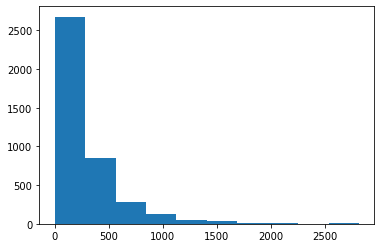

In [6]:
plt.hist(df['price_diff'])
plt.savefig(f'price_diff_hist_{TICKER}.png')

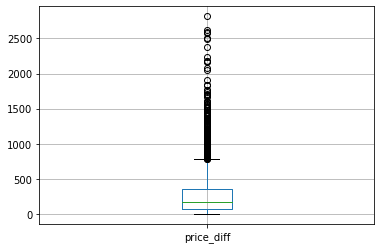

In [7]:
df.boxplot('price_diff')
plt.savefig(f'price_diff_boxplot_{TICKER}.png')

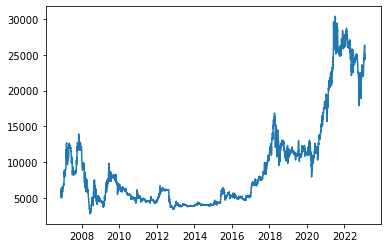

In [8]:
# plt.plot(df.loc[df['ticker'] == 'MBS', 'tradingDate'], df.loc[df['ticker'] == 'MBS', 'open'])
plt.plot(df['trading_date'], df['open_price'])
plt.savefig(f'open_price_ts_{TICKER}.png')

### 2008 financial crisis

Only take stocks that we do have data in this period

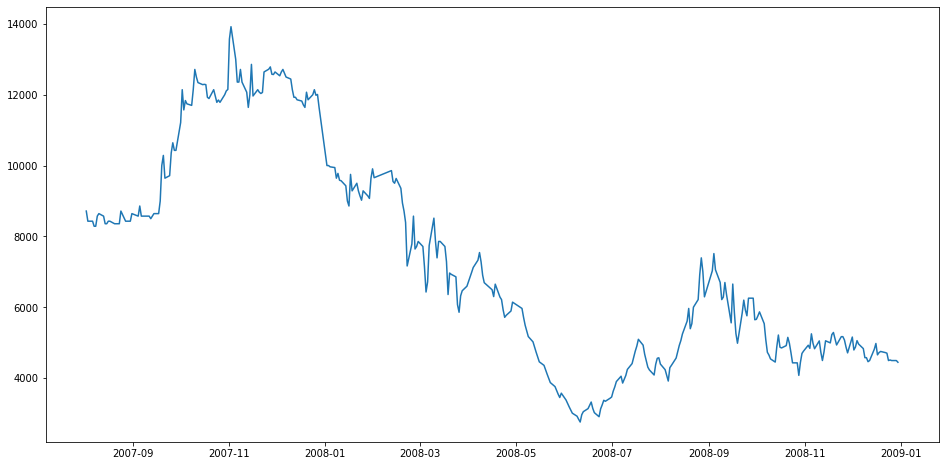

In [9]:
plt.figure(figsize=(16,8))
crisis_df = df[(df['trading_date'] > '2007-8-1') & (df['trading_date'] < '2008-12-31')]
if len(crisis_df) > 0:
  plt.plot(crisis_df['trading_date'], crisis_df['open_price'])
  plt.savefig(f'2008_crisis_{TICKER}.png')

### COVID pandemic

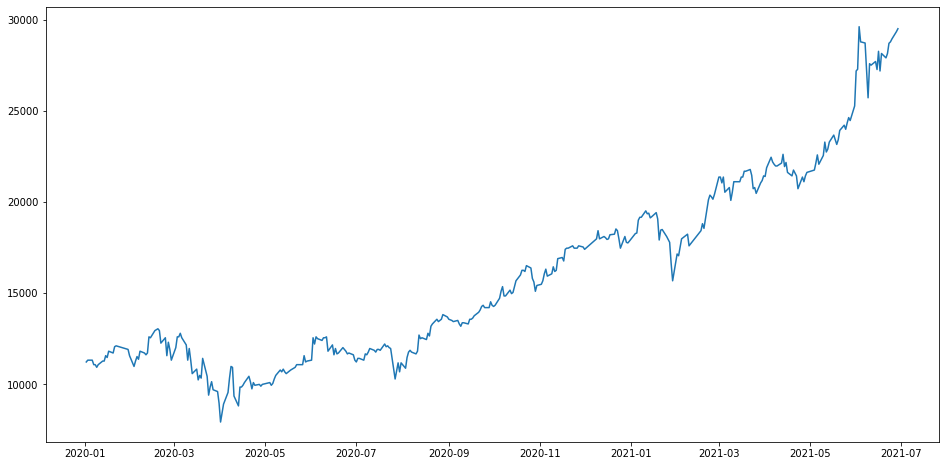

In [10]:
plt.figure(figsize=(16,8))
covid_df = df[(df['trading_date'] > '2020-1-1') & (df['trading_date'] < '2021-6-30')]
if len(covid_df) > 0:
  plt.plot(covid_df['trading_date'], covid_df['open_price'])
  plt.savefig(f'covid_{TICKER}.png')

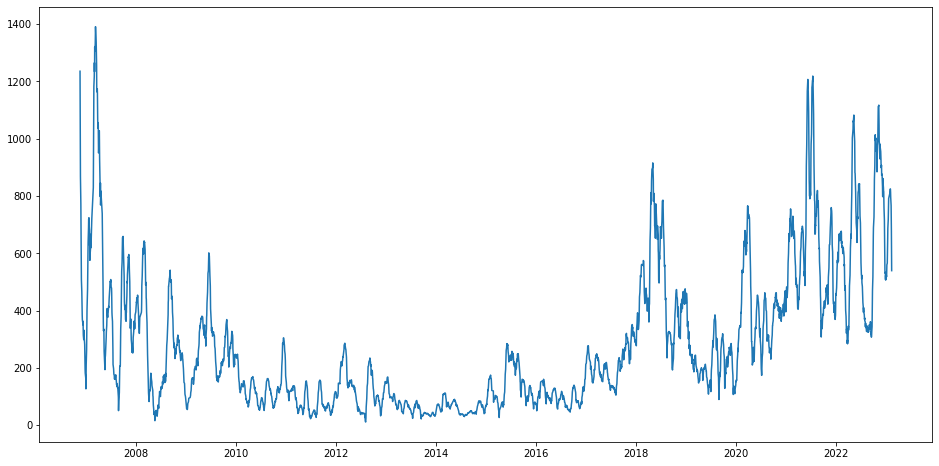

In [11]:
from scipy.signal import savgol_filter
plt.figure(figsize=(16,8))

# Dataset
x = df['trading_date']
y = df['price_diff']
y = savgol_filter(y, 31, 3)
 
# Plotting the Graph
plt.plot(x, y)
plt.savefig(f'price_diff_smoothed_{TICKER}.png')

### Seasonality

<Figure size 1152x576 with 0 Axes>

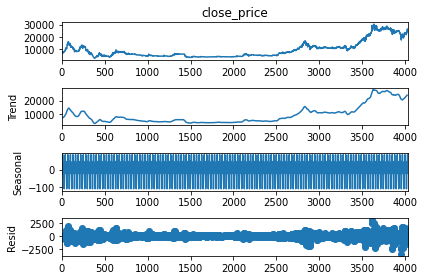

<Figure size 432x288 with 0 Axes>

In [12]:
#only first 5000 values are taken because it was looking very crowded
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(16,8))
result = seasonal_decompose(df['close_price'].head(5000), model='additive', period = 30)
result.plot()  
plt.show()
plt.savefig(f'seasonality_{TICKER}.png')

### Accumulation distribution

In [13]:
# plt.figure(figsize=(16,8))
# money_flow_volume = ((df['close_price'] - df['low_price']) - (df['high_price'] - df['close_price'])) / (df['high_price'] - df['low_price']) * df['volume']
# money_flow_volume = money_flow_volume.tolist()
# acc_dist = [0]
# for i in range(len(money_flow_volume)):
#   try:
#     acc_dist.append(acc_dist[i-1] + money_flow_volume[i])
#   except:
#     pass
# acc_dist = acc_dist[:-1]
# df['accumulation_distribution'] = acc_dist
# plt.plot(df['trading_date'], df['accumulation_distribution'])

### Chaikin Money Flow